In [1]:
import matplotlib.pyplot as plt
import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

from lcapt.analysis import make_feature_grid
from lcapt.lca import LCAConv2D
from lcapt.metric import compute_l1_sparsity, compute_l2_error
from lcapt.preproc import make_unit_var, make_zero_mean

In [2]:
BATCH_SIZE = 128
DEVICE = 2
EPOCHS = 25
FEATURES = 64  # number of dictionary features to learn
KERNEL_SIZE = 9  # height and width of each feature
LCA_ITERS = 800
LEARNING_RATE = 1e-3
LAMBDA = 0.05  # LCA threshold
PRINT_FREQ = 20
STRIDE = 2  # convolutional stride
TAU = 100  # LCA time constant

In [3]:
dset = CIFAR10('./data', download=True, transform=ToTensor())
dataloader = DataLoader(
    dset, 
    BATCH_SIZE, 
    shuffle=True, 
    num_workers=4, 
    drop_last=True,
    persistent_workers=True,
    pin_memory=True,
)

Files already downloaded and verified


In [4]:
lca = LCAConv2D(
    out_neurons=FEATURES,
    in_neurons=3,
    result_dir='./cifar_dictionary_learning',
    kernel_size=KERNEL_SIZE,
    stride=STRIDE,
    lambda_=LAMBDA,
    tau=TAU,
    lca_iters=LCA_ITERS,
    track_metrics=False,
    req_grad=True,
    input_unit_var=False,
    input_zero_mean=False
)
lca = lca.to(dtype=torch.float16, device=DEVICE)

In [5]:
optimizer = SGD(lca.parameters(), LEARNING_RATE, 0.1)
#scheduler = CosineAnnealingLR(optimizer, len(dset) // BATCH_SIZE, 1e-3)

In [6]:
l1, l2, energy = [], [], []

In [ ]:
for epoch in range(EPOCHS):
    if (epoch + 1) % 4 == 0:
        lca.lambda_ += 0.1

    for batch_num, (images, _) in enumerate(dataloader):
        images = images.to(dtype=torch.float16, device=DEVICE)
        images = make_unit_var(make_zero_mean(images))

        with torch.no_grad():
            code = lca(images)

        recon = lca.compute_recon(code, lca.get_weights())
        l1_sparsity = l1_sparsity = compute_l1_sparsity(code, lca.lambda_)
        l2_recon_error = compute_l2_error(images, recon)
        total_energy = l2_recon_error + l1_sparsity
        total_energy.backward()
        optimizer.step()
        #scheduler.step()
        optimizer.zero_grad()
        lca.normalize_weights()

        l1.append(l1_sparsity.item())
        l2.append(l2_recon_error.item())
        energy.append(total_energy.item())

        if batch_num % PRINT_FREQ == 0:
            print(f'Epoch: {epoch}; ',
                  f'Batch: {batch_num}; ',
                  f'L2 Recon Error: {round(l2[-1], 2)}; ',
                  f'L1 Sparsity: {round(l1[-1], 2)}; ',
                  f'Total Energy: {round(energy[-1], 2)}')

    torch.save(lca, f'lca_cifar.pt')
    #scheduler = CosineAnnealingLR(optimizer, len(dset) // BATCH_SIZE, 1e-3)

Text(0.5, 0, 'Step Number')

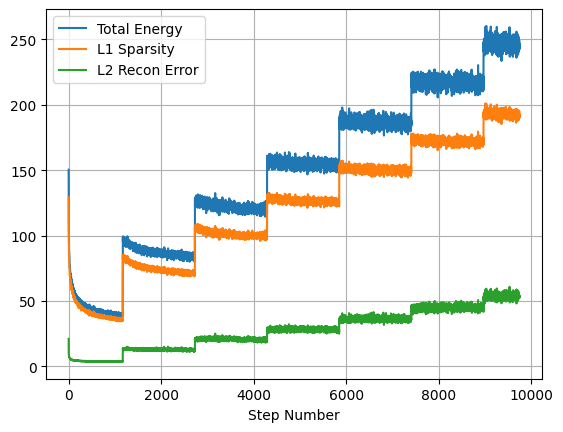

In [10]:
plt.plot(energy, label='Total Energy')
plt.plot(l1, label='L1 Sparsity')
plt.plot(l2, label='L2 Recon Error')
plt.legend()
plt.grid()
plt.xlabel('Step Number')

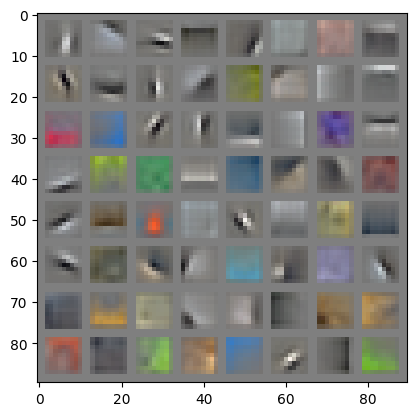

In [9]:
weight_grid = make_feature_grid(lca.get_weights())
plt.imshow(weight_grid.float().cpu().numpy())